> ## Formulación del problema.

* La mamografía es el método más efectivo para la detección del cáncer de mama disponible en la actualidad. Sin embargo, el bajo valor predictivo positivo de la biopsia mamaria como resultado de la interpretación de la mamografía conduce a aproximadamente un 70% de biopsias innecesarias con resultados benignos. Para reducir el alto número de biopsias mamarias innecesarias, se han propuesto varios sistemas de diagnóstico asistido por computadora (CAD) en los últimos años. Estos sistemas ayudan a los médicos en su decisión de realizar una biopsia de mama en una lesión sospechosa vista en una mamografía o realizar un examen de seguimiento a corto plazo en su lugar.
    
    Este dataset se puede utilizar para predecir la gravedad (benigna o maligna) de una lesión masiva mamográfica a partir de los atributos BI-RADS y la edad del paciente. Contiene una evaluación BI-RADS, la edad del paciente y tres atributos BI-RADS junto con la verdad absoluta (el campo de gravedad) para 516 masas benignas y 445 malignas que se han identificado en mamografías digitales de campo completo recopiladas en el Instituto de Radiología de la Universidad de Erlangen-Núremberg entre 2003 y 2006.
    
    Cada instancia tiene una evaluación BI-RADS asociada que varía de 1 (definitivamente benigna) a 5 (altamente sugestiva de malignidad) asignada en un proceso de doble revisión por médicos. Suponiendo que todos los casos con evaluaciones BI-RADS mayores o iguales a un valor dado (que varía de 1 a 5) son malignos y los demás casos son benignos, se pueden calcular sensibilidades y especificidades asociadas. Estas pueden ser una indicación de qué tan bien se desempeña un sistema CAD en comparación con los radiólogos.

    
* 6 atributos en total.

1. BI-RADS: 1 al 6
2. Age: Edad del paciente
3. Shape: forma de la masa: redonda=1 ovalada=2 lobular=3 irregular=4 
4. Margin: Margen de masa: circunscrito=1 microlobulado=2 oscurecido=3 mal definido=4 espiculado=5
5. Density: Densidad de masa: alto=1 iso=2 bajo=3 contiene grasa=4 
6. Severity: benigno=0 o maligno=1 

> ## Recopilación de datos.

* Link: https://archive.ics.uci.edu/dataset/161/mammographic+mass

> ## Explicación de actividad.

* Lo que se hará a continuación será importar el archivo.csv que contiene los datos a MySQL, y luego conectar Python con MySQL a traves de un conector para cargar el dataset y realizar los análisis correspondientes.
    Esto para realizar práctica con MySQL ya que se podría cargar directamente el csv a Python. 

In [67]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
cnx = mysql.connector.connect(user="root", password="",
                             host="localhost",
                            database="mammographic")

In [3]:
cursor = cnx.cursor()

In [4]:
create_table_sql = """CREATE TABLE IF NOT EXISTS mammographic (
    birads INT,
    age INT,
    shape INT,
    margin INT,
    density INT,
    severity INT
);
"""

In [5]:
load_data_sql = """
LOAD DATA INFILE 'C:/Users/Gimenez/Desktop/Roman/Machine\ Learning/SQL\ -\ Python/datos/mammographic_masses.data'
INTO TABLE mammographic
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n';
"""

In [6]:
cursor.execute(create_table_sql)

In [7]:
cursor.execute(load_data_sql)

In [8]:
cnx.commit()

In [9]:
query = "SELECT * FROM mammographic"

In [10]:
data = pd.read_sql(query, cnx)

In [11]:
cnx.close()

In [12]:
data.head()

,birads,age,shape,margin,density,severity
0,5,67,3,5,3,1
1,4,43,1,1,0,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,0,1


> ## Análisis de dataset.

In [13]:
data.shape

(961, 6)

In [14]:
data.isnull().sum()

birads      0
age         0
shape       0
margin      0
density     0
severity    0
dtype: int64

* ### Las variables independientes que son "birards", "age", "shape", "margin" y "density" tienen valores nulos representados con el valor 0 (cero). Se eliminarán del dataset aquellas observaciones en las que tengan al menos un valor 0 en dichas variables. 

In [15]:
data = data[(~(data["birads"] == 0)) & (~(data["age"] == 0)) &
    (~(data["shape"] == 0)) & (~(data["margin"] == 0)) & 
    (~(data["density"] == 0))]

In [16]:
data.head()

,birads,age,shape,margin,density,severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


In [17]:
data.shape

(825, 6)

> ## Análisis de variables.

In [18]:
for var in data.columns:
    print(var)
    print(data[var].unique())
    print()
    print(data[var].value_counts())
    print("\n","-"*50,"\n")

birads
[ 5  4  3  2 55  6]

4     468
5     316
3      24
6       9
2       7
55      1
Name: birads, dtype: int64

 -------------------------------------------------- 

age
[67 58 28 57 76 42 36 60 54 52 59 56 75 45 55 46 39 81 78 50 62 64 74 80
 49 73 68 66 25 44 33 71 84 51 24 40 86 65 53 47 63 41 34 23 87 21 19 35
 37 79 85 48 72 43 69 38 32 70 77 61 27 83 88 31 29 18 26 93 30 22 96 20]

67    30
59    29
66    28
57    27
46    25
      ..
88     1
93     1
26     1
18     1
20     1
Name: age, Length: 72, dtype: int64

 -------------------------------------------------- 

shape
[3 4 1 2]

4    375
1    190
2    179
3     81
Name: shape, dtype: int64

 -------------------------------------------------- 

margin
[5 1 4 3 2]

1    320
4    251
5    126
3    105
2     23
Name: margin, dtype: int64

 -------------------------------------------------- 

density
[3 2 1 4]

3    750
2     56
1     11
4      8
Name: density, dtype: int64

 -------------------------------------------------

In [19]:
data["birads"].value_counts()

4     468
5     316
3      24
6       9
2       7
55      1
Name: birads, dtype: int64

* ### En la variable "birads" hay un valor 55. Lo transformaremos en valor 5 porque puede haber sido un error de tipeo.

In [20]:
data["birads"].replace({55:5}, inplace=True)

In [21]:
data["birads"].value_counts()

4    468
5    317
3     24
6      9
2      7
Name: birads, dtype: int64

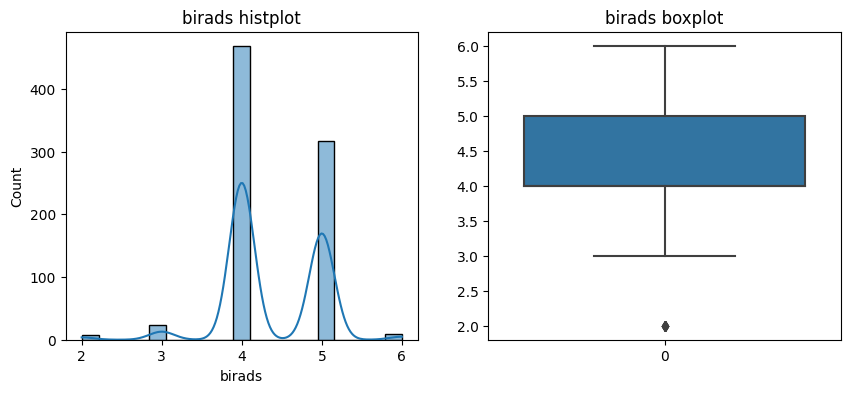

count    825.000000
mean       4.360000
std        0.601455
min        2.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: birads, dtype: float64


 ------------------------------------------------------------------------------------------ 



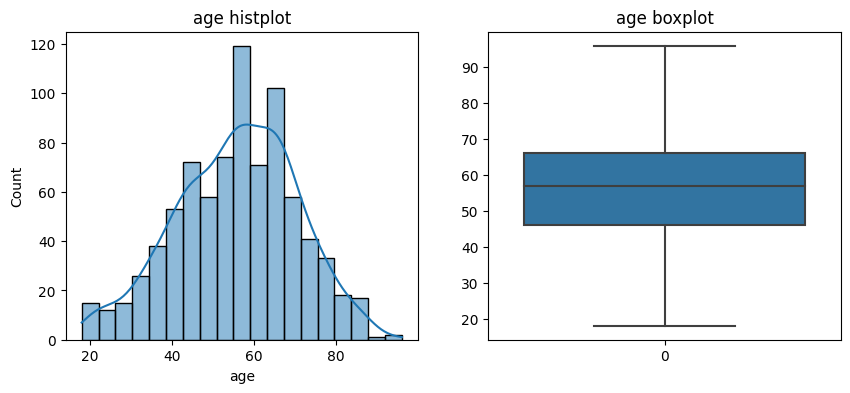

count    825.000000
mean      55.738182
std       14.683532
min       18.000000
25%       46.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: age, dtype: float64


 ------------------------------------------------------------------------------------------ 



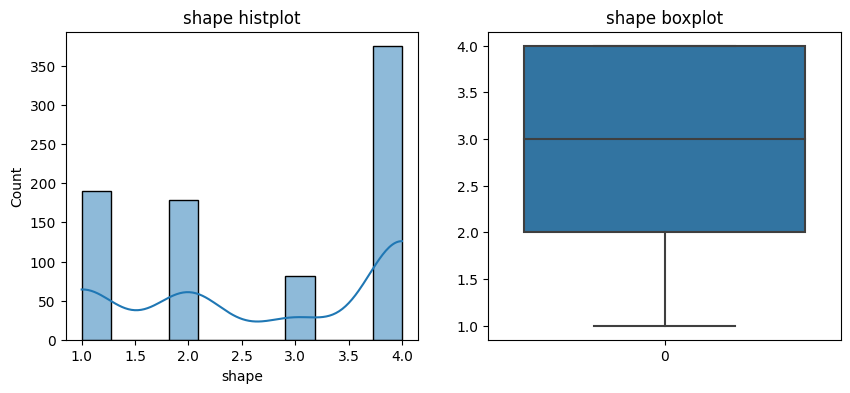

count    825.000000
mean       2.776970
std        1.242923
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: shape, dtype: float64


 ------------------------------------------------------------------------------------------ 



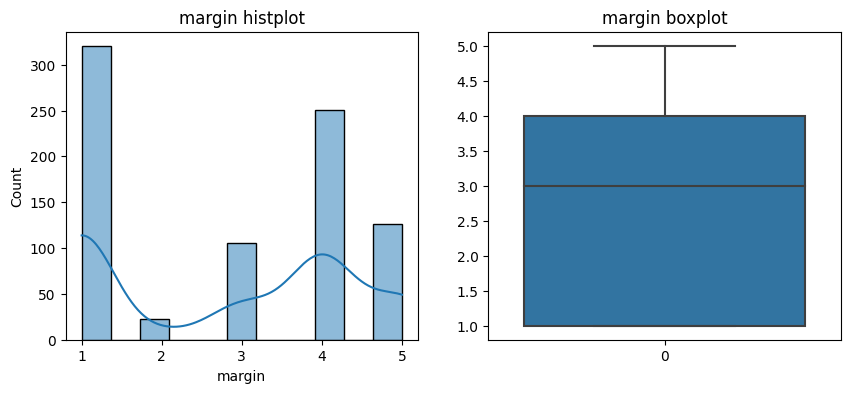

count    825.000000
mean       2.806061
std        1.568412
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: margin, dtype: float64


 ------------------------------------------------------------------------------------------ 



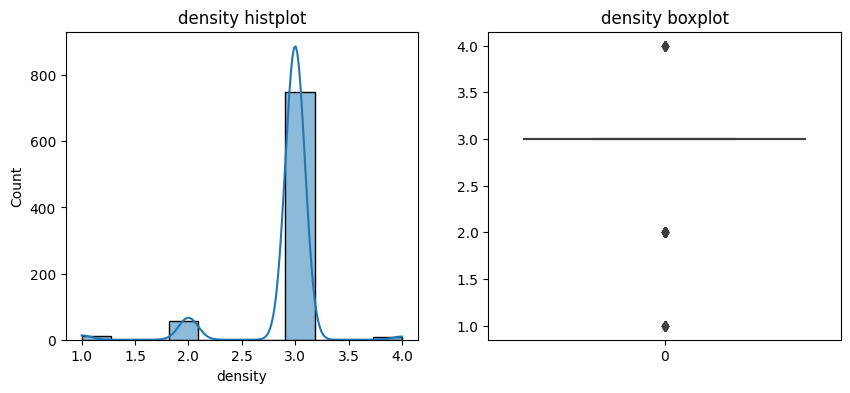

count    825.000000
mean       2.915152
std        0.351937
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: density, dtype: float64


 ------------------------------------------------------------------------------------------ 



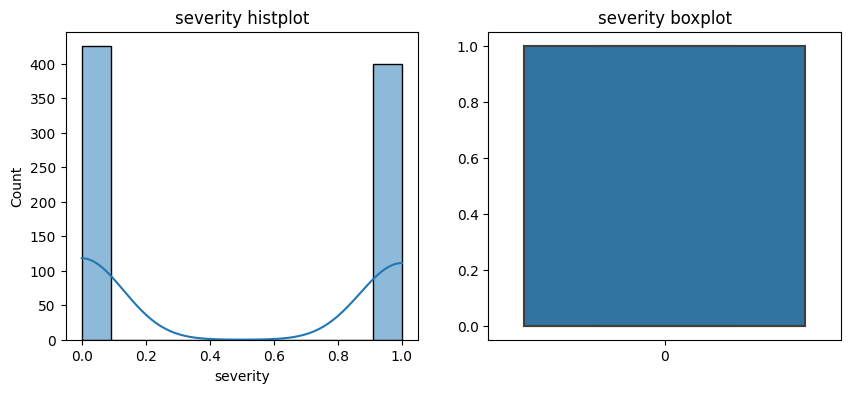

count    825.000000
mean       0.484848
std        0.500074
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: severity, dtype: float64


 ------------------------------------------------------------------------------------------ 



In [22]:
for var in data.columns:
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    sns.histplot(data[var], kde=True)
    plt.title(var+" histplot")
    
    plt.subplot(1,2,2)
    sns.boxplot(data[var])
    plt.title(var+" boxplot")
    
    plt.show()
    
    print()
    display(data[var].describe())
    print("\n","-"*90,"\n")

* #### En la variable "birads" la categoría más presente es la 4 seguida de la 5.
* #### La edad promedio de los/las pacientes en el dataset es de 55 años.
* #### La forma de la masa más común de encontrar según los datos en el dataset es la forma 4 (irregular).
* #### El margen de la masa que más se observa en el dataset es el 1 (circunscrito) y el que menos se observa es el 2 (microlobulado)
* #### La densidad de la masa mas observada es la 3 (baja densidad).
* #### En el dataset hay 425 observaciones que son benignas y 400 que son malignas. 

Datos de ' birads ' según severidad.



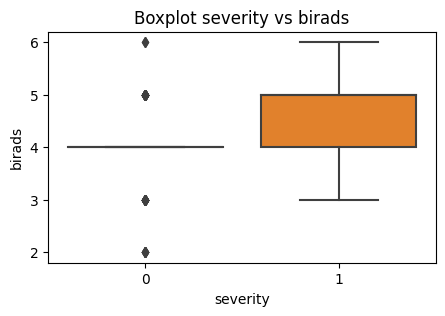

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
0,425.0,4.002353,0.452971,2.0,4.0,4.0,4.0,6.0
1,400.0,4.740000,0.498016,3.0,4.0,5.0,5.0,6.0



 ------------------------------------------------------------------------------------------ 

Datos de ' age ' según severidad.



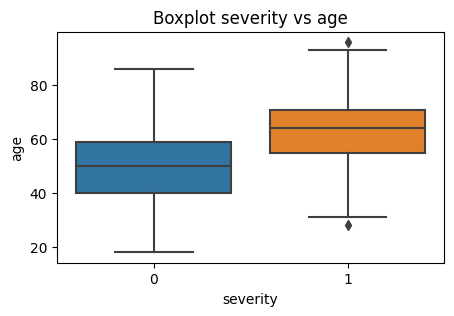

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
0,425.0,49.287059,13.726866,18.0,40.0,50.0,59.0,86.0
1,400.0,62.592500,12.393565,28.0,55.0,64.0,71.0,96.0



 ------------------------------------------------------------------------------------------ 

Datos de ' shape ' según severidad.



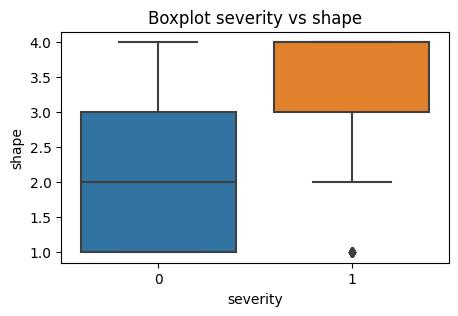

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
0,425.0,2.096471,1.100005,1.0,1.0,2.0,3.0,4.0
1,400.0,3.500000,0.941923,1.0,3.0,4.0,4.0,4.0



 ------------------------------------------------------------------------------------------ 

Datos de ' margin ' según severidad.



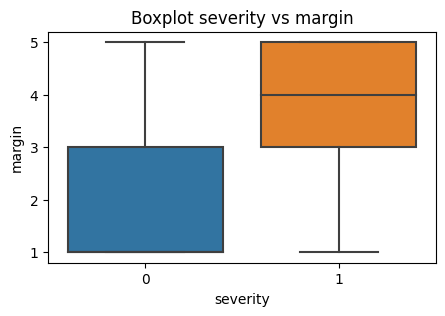

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
0,425.0,1.929412,1.380356,1.0,1.0,1.0,3.0,5.0
1,400.0,3.737500,1.169193,1.0,3.0,4.0,5.0,5.0



 ------------------------------------------------------------------------------------------ 

Datos de ' density ' según severidad.



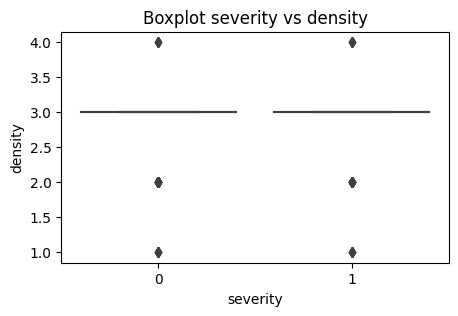

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
0,425.0,2.891765,0.379365,1.0,3.0,3.0,3.0,4.0
1,400.0,2.940000,0.318832,1.0,3.0,3.0,3.0,4.0



 ------------------------------------------------------------------------------------------ 



In [23]:
for var in data.columns.drop(["severity"]):
    print("Datos de '",var,"' según severidad.")
    print()
    
    plt.figure(figsize=(5,3))
    sns.boxplot(x=data["severity"], y=data[var])
    plt.title("Boxplot severity vs "+var)
    plt.show()
    
    display(data.groupby("severity")[var].describe())
    print("\n","-"*90,"\n")

* #### Según las masas benignas, el promedio de los datos son: 
   * bi-rads: categoría 4.
   * Edad: 49 años.
   * Forma: Ovalada.
   * Margen: Microlobulado.
   * Densidad: Baja densidad.
* #### Según las masas malignas, el promedio de los datos son: 
   * bi-rads: categoría 5.
   * Edad: 62 años.
   * Forma: Lobular e Irregular.
   * Margen: Oscurecido y mal definido.
   * Densidad: Baja densidad.

> ## Construcción y evaluación de los modelos.

## Regresión Logística.

* ### Selección de rasgos y validación cruzada.

In [24]:
data_lr = data.copy()

In [25]:
X = data_lr.drop(["severity"], axis=1)
Y = data_lr["severity"]

In [26]:
lr = LogisticRegression(solver="liblinear")

In [27]:
for i in reversed(range(1,len(data_lr.columns))):
    rfe = RFE(lr, n_features_to_select=i)
    rfe = rfe.fit(X,Y)
    
    var_select = pd.DataFrame(list(zip(X, rfe.support_, rfe.ranking_)), columns=["variable", "support", "ranking"])
    
    print("Modelo de regresión logística con ", i, " variables")
    display(var_select)
    
    X_new = data_lr[var_select[var_select["ranking"]==1]["variable"].unique()]
    x_train, x_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.3, random_state=0)
    
    lr = LogisticRegression(solver="liblinear")
    lr.fit(x_train, y_train)
    score = lr.score(x_test, y_test)
    print("Score del modelo con ", i," variables",":",score)
    scores = cross_val_score(LogisticRegression(),
                         X_new,Y,
                         scoring="accuracy",
                         cv=10)
    
    print("Score de la validación cruzada: ",scores.mean())
    
    print("\n","-"*40,"\n")

Modelo de regresión logística con  5  variables


,variable,support,ranking
0,birads,True,1
1,age,True,1
2,shape,True,1
3,margin,True,1
4,density,True,1


Score del modelo con  5  variables : 0.7903225806451613
Score de la validación cruzada:  0.8398618865706731

 ---------------------------------------- 

Modelo de regresión logística con  4  variables


,variable,support,ranking
0,birads,True,1
1,age,False,2
2,shape,True,1
3,margin,True,1
4,density,True,1


Score del modelo con  4  variables : 0.8024193548387096
Score de la validación cruzada:  0.8386717602115781

 ---------------------------------------- 

Modelo de regresión logística con  3  variables


,variable,support,ranking
0,birads,True,1
1,age,False,3
2,shape,False,2
3,margin,True,1
4,density,True,1


Score del modelo con  3  variables : 0.8024193548387096
Score de la validación cruzada:  0.8338084043491036

 ---------------------------------------- 

Modelo de regresión logística con  2  variables


,variable,support,ranking
0,birads,True,1
1,age,False,4
2,shape,False,3
3,margin,False,2
4,density,True,1


Score del modelo con  2  variables : 0.7782258064516129
Score de la validación cruzada:  0.8301645606817514

 ---------------------------------------- 

Modelo de regresión logística con  1  variables


,variable,support,ranking
0,birads,True,1
1,age,False,5
2,shape,False,4
3,margin,False,3
4,density,False,2


Score del modelo con  1  variables : 0.8024193548387096
Score de la validación cruzada:  0.8301645606817514

 ---------------------------------------- 



#### El modelo realizado con todas las variables independientes (5) es el que mayor score tiene en su validación cruzada con un 83,9% de coincidencia entre los valores predecidos y los valores actuales.

* ### Evaluación del modelo de regresión logística.

In [28]:
from sklearn import metrics

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                test_size=0.3, random_state=0)

In [30]:
lr = LogisticRegression(solver="liblinear")
lr.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [31]:
probs = lr.predict_proba(x_test)
probs

array([[0.6228578 , 0.3771422 ],
       [0.9186835 , 0.0813165 ],
       [0.90573409, 0.09426591],
       [0.0568308 , 0.9431692 ],
       [0.49478886, 0.50521114],
       [0.90881638, 0.09118362],
       [0.1799037 , 0.8200963 ],
       [0.96210941, 0.03789059],
       [0.10134275, 0.89865725],
       [0.05469895, 0.94530105],
       [0.70798663, 0.29201337],
       [0.92137912, 0.07862088],
       [0.25076122, 0.74923878],
       [0.29341204, 0.70658796],
       [0.54527884, 0.45472116],
       [0.93749906, 0.06250094],
       [0.29067698, 0.70932302],
       [0.91560687, 0.08439313],
       [0.54527884, 0.45472116],
       [0.31222494, 0.68777506],
       [0.20220646, 0.79779354],
       [0.86502978, 0.13497022],
       [0.17733227, 0.82266773],
       [0.95742379, 0.04257621],
       [0.1050904 , 0.8949096 ],
       [0.9186835 , 0.0813165 ],
       [0.87420849, 0.12579151],
       [0.9604594 , 0.0395406 ],
       [0.24323067, 0.75676933],
       [0.9323399 , 0.0676601 ],
       [0.

In [32]:
prob = probs[:,1]
threshold = 0.5
prob_df = pd.DataFrame(prob)
prob_df["prediction"] = np.where(prob_df[0]>threshold,1,0)
prob_df["actual"] = list(y_test)
prob_df.head()

,0,prediction,actual
0,0.377142,0,1
1,0.081317,0,0
2,0.094266,0,0
3,0.943169,1,1
4,0.505211,1,0


In [33]:
print("El "+str(metrics.accuracy_score(y_test, prob_df["prediction"])*100)+" % de los casos coinciden")

El 79.03225806451613 % de los casos coinciden


In [34]:
prob_df["prediction"].value_counts()

1    129
0    119
Name: prediction, dtype: int64

In [35]:
print("Probabilidad de tener una masa benigna "+str(float(prob_df["prediction"].value_counts()[0]/len(prob_df)))+"%")

Probabilidad de tener una masa benigna 0.4798387096774194%


* ### Matrices de confusión y curvas ROC.

In [36]:
threshold = [0.04, 0.05, 0.08, 0.10, 0.12, 0.18, 0.20, 0.25, 0.30, 0.40]
sensitivities = [1]
especifities_1 = [1]

for t in threshold:
    prob_df["prediction"] = np.where(prob_df[0]>=t,1,0)
    prob_df["actual"] = list(y_test)
    
    confusion_matrix = pd.crosstab(prob_df["prediction"],
                                  prob_df["actual"])
    
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FN = confusion_matrix[1][0]
    FP = confusion_matrix[0][1]
    
    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espec_1 = 1-(TN/(TN+FP))
    especifities_1.append(espec_1)
    
sensitivities.append(0)
especifities_1.append(0)

In [37]:
sensitivities

[1,
 0.9921259842519685,
 0.9921259842519685,
 0.968503937007874,
 0.952755905511811,
 0.9448818897637795,
 0.9291338582677166,
 0.9291338582677166,
 0.905511811023622,
 0.8976377952755905,
 0.8740157480314961,
 0]

In [38]:
especifities_1

[1,
 0.8677685950413223,
 0.8264462809917356,
 0.7107438016528926,
 0.6363636363636364,
 0.5950413223140496,
 0.4628099173553719,
 0.4380165289256198,
 0.42148760330578516,
 0.3801652892561983,
 0.3305785123966942,
 0]

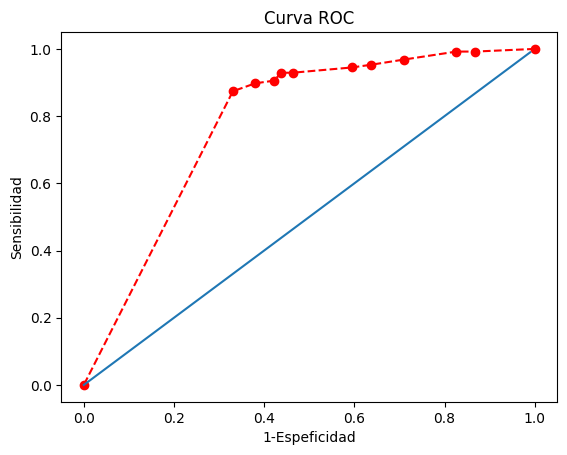

In [39]:
plt.plot(especifities_1,sensitivities,marker="o",
        linestyle="--",color="r")
x = [i*0.01 for i in range(100)]
y = [i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Espeficidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")
plt.show()

## Árbol de decisión.
* ### Encontrar el mejor valor de máxima profundidad para el árbol.

In [40]:
data_tree = data.copy()

In [41]:
X = data_tree.drop(["severity"], axis=1)
Y = data_tree["severity"]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [43]:
for i in range(1,len(X.columns)+1):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=i, random_state=0)
    tree.fit(x_train,y_train)
    
    cv = KFold(n_splits=10, shuffle=True, random_state=0)
    score = np.mean(cross_val_score(tree,
                                   X,Y,
                                   scoring="accuracy",
                                   cv=cv))
    print("Score para i = ",i," es de ",score)
    print("Orden de importancia de los atributos:")
    df_importance = pd.DataFrame(list(zip(X.columns,tree.feature_importances_)), columns=["Variable", "Order"]) 
    display(df_importance.sort_values("Order", ascending=False))
    print("\n","-"*60,"\n")

Score para i =  1  es de  0.8304290332059947
Orden de importancia de los atributos:


,Variable,Order
0,birads,1.0
1,age,0.0
2,shape,0.0
3,margin,0.0
4,density,0.0



 ------------------------------------------------------------ 

Score para i =  2  es de  0.8086688216279754
Orden de importancia de los atributos:


,Variable,Order
0,birads,0.797187
2,shape,0.174343
1,age,0.028470
3,margin,0.000000
4,density,0.000000



 ------------------------------------------------------------ 

Score para i =  3  es de  0.8328974434322657
Orden de importancia de los atributos:


,Variable,Order
0,birads,0.722086
2,shape,0.157918
1,age,0.104571
3,margin,0.015425
4,density,0.000000



 ------------------------------------------------------------ 

Score para i =  4  es de  0.8232148104613575
Orden de importancia de los atributos:


,Variable,Order
0,birads,0.690146
2,shape,0.149006
1,age,0.131108
3,margin,0.029740
4,density,0.000000



 ------------------------------------------------------------ 

Score para i =  5  es de  0.8111372318542462
Orden de importancia de los atributos:


,Variable,Order
0,birads,0.652140
2,shape,0.157143
1,age,0.144041
3,margin,0.028102
4,density,0.018574



 ------------------------------------------------------------ 



* #### Para profundidad igual a 3 alcanza la mayor puntuación.
* #### El atributo que será el nodo raíz es "bi-rads" ya que es el que mayor importancia tiene.

In [44]:
tree_clf = DecisionTreeClassifier(criterion="entropy",
                             max_depth=3,
                             random_state=0)
tree_clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [45]:
preds = tree_clf.predict(x_test)

* ### Evaluación del modelo del árbol de decisión.

In [46]:
crosstab_pred = pd.crosstab(y_test,preds, rownames=["Actual"], colnames=["Predictions"])
crosstab_pred

Predictions,0,1
Actual,,
0,100,21
1,30,97


In [47]:
crosstab_pred.astype("float").div(crosstab_pred.sum(axis=1), axis=0)

Predictions,0,1
Actual,,
0,0.826446,0.173554
1,0.236220,0.763780


#### Un 82,6% de las masas benignas estan bien clasificadas y un 76,3% de las masas malignas estan bien clasificadas.

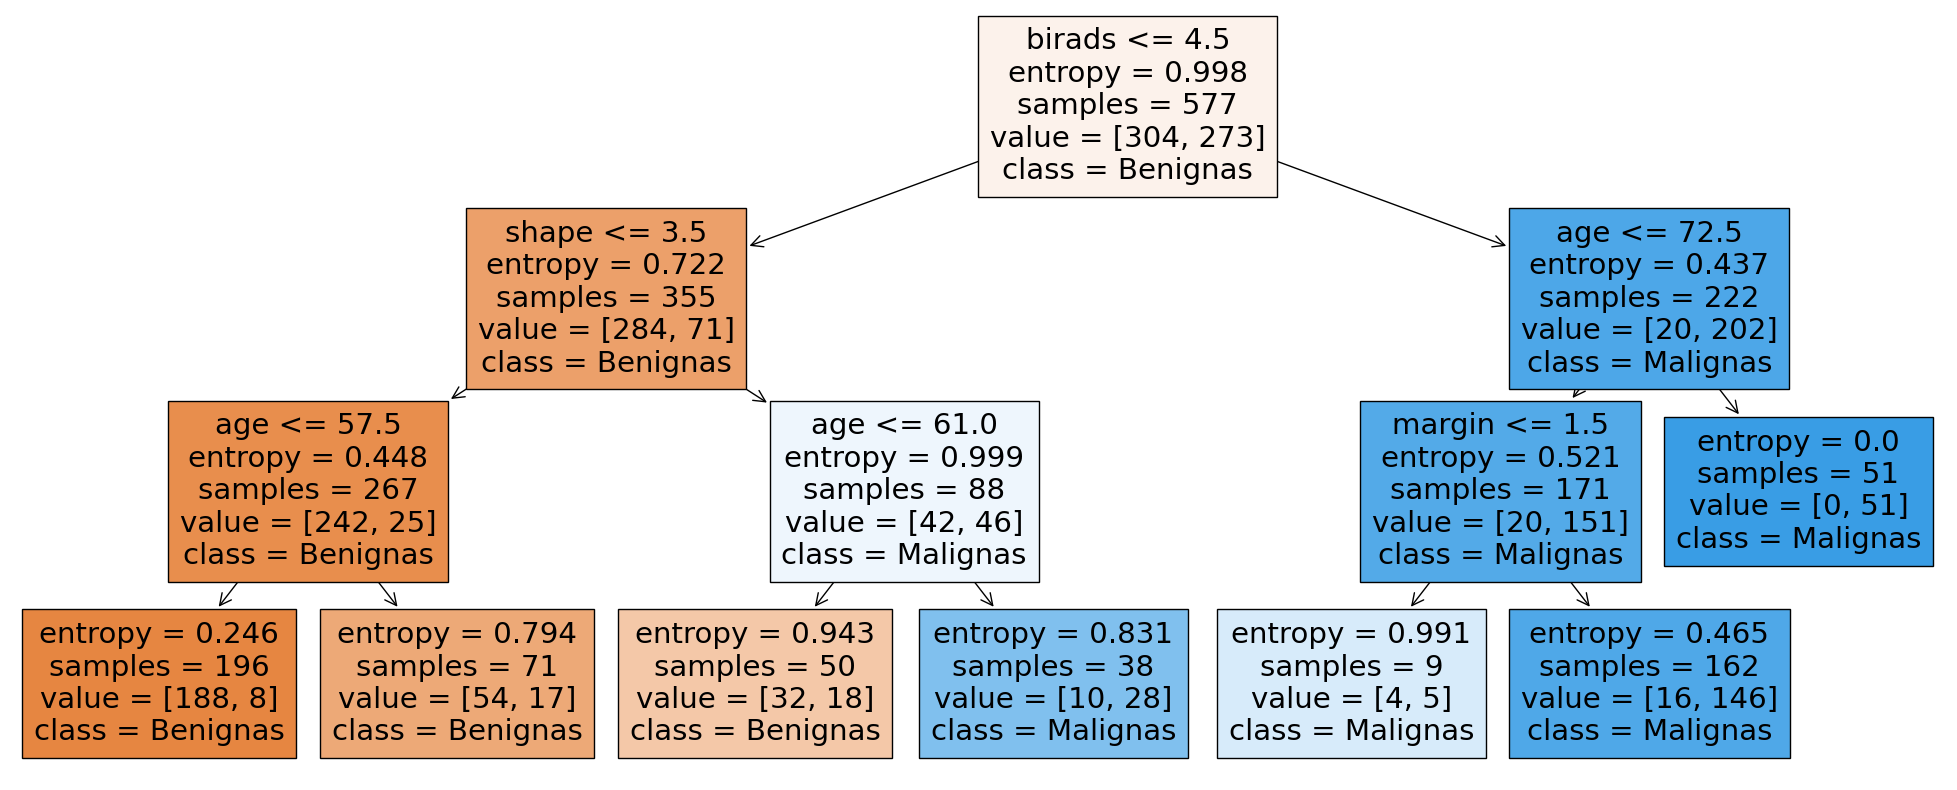

In [48]:
plt.figure(figsize=(25,10))
plot_tree(tree_clf,
          feature_names=x_test.columns,
          filled=True,
         class_names = ["Benignas","Malignas"])
plt.show()

## Bosque aleatorio.

In [49]:
data_forest = data.copy()

In [50]:
X = data_forest.drop(["severity"], axis=1)
Y = data_forest["severity"]

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [52]:
forest = RandomForestClassifier(oob_score=True, n_estimators=100, random_state=0)
forest = forest.fit(x_train, y_train)

In [53]:
forest.oob_score_

0.779896013864818

In [54]:
forest_pred = forest.predict(x_test)

In [55]:
accuracy_score(forest_pred, y_test)

0.782258064516129

* #### El bosque aleatorio con un total de 100 árboles nos da un score o una precisión en la predicción de 78,2%

## Support vector classifier.

In [56]:
data_svc = data.copy()

In [57]:
X = data_svc.drop(["severity"], axis=1)
Y = data_svc["severity"]

* ### Normalizamos las variables independientes.

In [58]:
X = (X-X.min())/(X.max()-X.min())
X.head()

,birads,age,shape,margin,density
0,0.75,0.628205,0.666667,1.00,0.666667
2,0.75,0.512821,1.000000,1.00,0.666667
3,0.50,0.128205,0.000000,0.00,0.666667
8,0.75,0.500000,0.000000,1.00,0.666667
10,0.75,0.743590,0.000000,0.75,0.666667


In [59]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

* ### Vamos a elegir los mejores parametros del modelado realizando una validación cruzada.

In [60]:
parameters = [
    {
        "kernel": ["rbf"],
        "gamma": [1e-4,1e-3,1e-2,0.1,0.2,0.5],
        "C": [1,10,100,1000]
    },
    {
        "kernel":["linear"],
        "C": [1,10,100,1000]
    },
    {
        "kernel":["poly"],
        "C": [1,10,100,1000]
    }
]

In [61]:
clf = GridSearchCV(svm.SVC(decision_function_shape="ovr"),
                  param_grid=parameters, cv=5)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['poly']}])

In [62]:
clf.best_params_

{'C': 100, 'gamma': 0.2, 'kernel': 'rbf'}

In [63]:
y_pred = clf.predict(x_test)

In [64]:
y_pred

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1], dtype=int64)

#### Los mejores parametros para support vector machine son kernel radial basis function, C=100 y gamma=0.2.


* ### Evaluación del modelo SVC.

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       121
           1       0.84      0.80      0.82       127

    accuracy                           0.82       248
   macro avg       0.82      0.82      0.82       248
weighted avg       0.82      0.82      0.82       248



In [68]:
mat = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

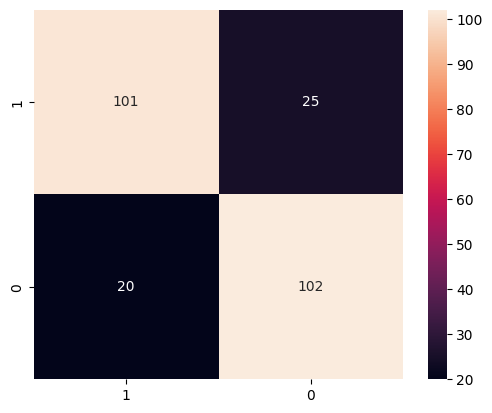

In [69]:
sns.heatmap(mat.T, square=True, annot=True, fmt="d",
           cbar=True,xticklabels=y_test.unique(),
           yticklabels=y_test.unique())

#### El 82% de los datos se clasifican correctamente. 